# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file   = "data/train.p"
validation_file = "data/valid.p"
testing_file    = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test =X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))  #https://stackoverflow.com/a/12282286

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import random
import pandas as pd
import numpy as np
import textwrap
from PIL     import Image
from os      import listdir
from os.path import isfile, join, basename

#### Helper Classes and Functions

Classes to help in exploring and viewing data:

In [171]:
random.seed()

class Logger:
    '''
    Simple logger for project to make output messages look clean"
    '''
    
    def __init__(self, name, owner=None):
        if owner is not None:
            # https://stackoverflow.com/a/7983848
            name = name + "-" + str(id(owner))[-4:]
        
        self.name = name
        return
        
    def log(self, msg):
        print (self.name + " | " + msg)
        return


class SignNames_CSV:
    '''
    Provides access to the signnames.csv to retrieve sign names.
    '''

    def __init__(self):
        self.df = pd.read_csv("signnames.csv")
        return
    
    def signName(self, class_id):
        return self.df.at[class_id, 'SignName']
    
signnames_csv = SignNames_CSV()


def signName(class_id):
    '''
    Returns name of sign given class_id.
    
    Params:
    - class_id: integer from 0-42 representing id number of sign name
    
    Notes: 
    - Example: signName(0) retturns "Speed limit (20km/h)".
    - Use to map dataset label to sign name
    '''
    return signnames_csv.signName(class_id)


class TrafficSignsDataset:
    '''
    Wrapper for the training, validation, and testing datasets.
    '''
    
    def __init__(self, *args):
        
        self.logger = Logger("TrafficSignsDataset", self)
        
        if len(args) == 3:
            # initialized with imags, labels and n_classes
            images, labels, n_classes = args
        else:
            # len args == 2
            # initializes with folder_name and n_classes
            folder_name, n_classes = args
            images, labels = self.loadFolder(folder_name)
            
        self.org_X = images
        self.org_y = labels
            
        self.X = self.org_X.copy()
        self.y = self.org_y.copy()
        
        self.n_classes = n_classes
        
        return

    def loadFolder(self, folder_name):
    
        msg = "Loading signs from {}..."
        self.logger.log(msg.format(folder_name))

        pathnames = [join(folder_name, f) 
                     for f in listdir(folder_name) if isfile(join(folder_name, f))]

        n = 0
        images = []
        labels = []

        for pathname in pathnames:
            
            filename = basename(pathname) 
            classId = filename.split(",")[0]

            pil_img = Image.open(pathname).convert('RGB')
            
            pil_img20x20 = pil_img.resize((20, 20), Image.BILINEAR)
            img = np.pad (np.array(pil_img20x20), [(6, 6), (6, 6), (0, 0)])
            
            '''
            #if not padding, use:
            pil_img32x32 = pil_img.resize((32, 32), Image.BILINEAR)
            img = np.array(pil_img32x32)
            '''

            labels.append(classId)
            images.append(img)

            msg = "Loaded {} with label {}."
            self.logger.log(msg.format(filename, classId))

            n += 1

        msg = "...{} signs loaded."
        self.logger.log (msg.format(n))
        
        return images, labels
    
    def data(self):
        return (self.X, self.y)
    
    def processImages(self, img_processors):
        
        self.logger.log("Processing images...")
        
        for img_processor in img_processors:
            
            msg = "Applying {}() to images."
            self.logger.log(msg.format(img_processor.__name__))
            
            self.X = [img_processor(img) for img in self.X]
            
        self.logger.log("...images processed.")            
        
        return
    
    def addFakes (self, img_processors):
        
        self.logger.log("Adding fake images...")
        max_samples = np.max(np.bincount(self.y))
        
        for classId in range(self.n_classes):

            x = self.X[self.y == classId]
            y = self.y[self.y == classId]

            n_x = x.shape[0]

            aug_x = np.array([])
            aug_y = np.array([])

            if n_x < max_samples:

                n_repeats = (max_samples - n_x) // n_x
                n_remain = (max_samples - n_x) % n_x

                aug_x = np.repeat(x, n_repeats, axis=0)
                aug_x = np.concatenate ((aug_x, x[:n_remain]))
                for img_processor in img_processors:
                    aug_x = np.array([img_processor(img) for img in aug_x])

                aug_y = np.repeat(y, n_repeats, axis=0)
                aug_y = np.concatenate ((aug_y, y[:n_remain]))
                
                samples_added = max_samples - n_x
                msg = "Added {} fake images for sign classId {}."
                self.logger.log(msg.format(samples_added, classId))
                
            if aug_x.shape[0] > 0:
                self.X = np.concatenate((self.X, aug_x))
                self.y = np.concatenate((self.y, aug_y))
                
        self.X = np.array(self.X, dtype=np.uint8)
        self.logger.log ("...fake images added.")

        return
    
    def restoreOrgImages(self):
        
        self.X = np.array(self.org_X, dtype=np.uint8)
        self.y = np.array(self.org_y)
        
        self.logger.log("Original images and labels restored.")
        
        return
    
class Viewer:
    '''
    Provides methods for plotting data on notebook.
    '''
    
    def __init__(self):
        return
    
    def imShowTrainingSigns(self, trainingSigns):
        
        ds = list(zip(trainingSigns.y, trainingSigns.X))
        df = pd.DataFrame(data=ds, columns=['Label', 'Image'])

        n_samples = 6
        for classId in range(trainingSigns.n_classes):
            # https://pandas.pydata.org/pandas-docs/version/0.15/cookbook.html#building-criteria
            df_sel = df.loc[(df['Label'] == classId), 'Image'].sample(n_samples)
            
            fig, axes = plt.subplots(1, n_samples, figsize=(11, 1.25))
            plt.axis('off')
            fig.suptitle(signName(classId), y=1.12)
            for i in range(n_samples):
                axes[i].xaxis.set_visible(False)
                axes[i].yaxis.set_visible(False)
                axes[i].imshow(df_sel.iloc[i])
            plt.show()    
        
        return
    
    def imShowTrainingSigns5x5(self, trainingSigns):
        fig = plt.figure(figsize=(11,11))
        num_rows = 5
        num_cols = 5
        for i in range(num_cols*num_rows):
            img = random.choice(trainingSigns.X)
            ax = plt.subplot(num_rows, num_cols, i + 1)
            ax.imshow(img)
        plt.show()
        return
    
    def imShowImages(self, images, titles=None):
        
        n_images = len(images)
        n_cols = 5
        n_rows = n_images//n_cols + 1
        plt.figure(figsize=(11, (2.5 * n_rows)))
        for i, img in enumerate(images):
            ax = plt.subplot(n_rows, n_cols, i + 1)
            ax.imshow(img)
            if titles is not None:
                ax.set_title(titles[i])
            
        return

    def barhPctBySigns(self, trainingSigns, validSigns, testSigns):
        y_train = trainingSigns.y
        y_valid = validSigns.y
        y_test  = testSigns.y
        
        bincount_y_train = np.bincount(y_train)
        bincount_y_valid = np.bincount(y_valid)
        bincount_y_test  = np.bincount(y_test)
        # bin_count[i] = num samples for sign i (where i=classId)

        pct_y_train = bincount_y_train / sum(bincount_y_train)
        pct_y_valid = bincount_y_valid / sum(bincount_y_valid)
        pct_y_test  = bincount_y_test  / sum(bincount_y_test)
        # pct_y_train[i] = percentage of total samples of sign i 

        pct_y_train_sorted_idx = np.argsort(pct_y_train)
        # pct_y_train_sorted_idx an array of sign classIds sorted by their percentage

        # ref: https://stackoverflow.com/a/59421062
        bar_wid = 0.3

        y_pos      = np.arange(len(pct_y_train))
        pcts       = [pct_y_train[class_id] for class_id in pct_y_train_sorted_idx]
        pcts_valid = [pct_y_valid[class_id] for class_id in pct_y_train_sorted_idx]
        pcts_test  = [pct_y_test[class_id] for class_id in pct_y_train_sorted_idx]
        y_labels   = [textwrap.fill(signName(class_id), width=25) 
                      for class_id in pct_y_train_sorted_idx]

        fig, ax = plt.subplots(figsize=(11, 35))

        ax.barh(y_pos + 2*bar_wid, pcts,       bar_wid, label="Training")
        ax.barh(y_pos + bar_wid,   pcts_valid, bar_wid, label="Valid")
        ax.barh(y_pos,             pcts_test,  bar_wid, label="Test")

        ax.set_yticks(y_pos  + bar_wid)
        ax.set_yticklabels(y_labels)
        ax.set_xlabel('Percentage of Sample')
        ax.set_title("Percentage of Sample by Sign and Dataset")

        plt.legend(loc='best')
        plt.margins(y=0)
        plt.show()

        return
    
    def barhCountTrainingSigns(self, trainingSigns):
        sign_count_y_train = np.bincount(trainingSigns.y)

        # ref: https://stackoverflow.com/a/59421062
        y_pos        = np.arange(len(sign_count_y_train))
        counts_train = [sign_count_y_train[class_id] 
                        for class_id in range(trainingSigns.n_classes)]
        
        y_labels     = [textwrap.fill(signName(class_id), width=25) 
                        for class_id in range(trainingSigns.n_classes)]

        fig, ax = plt.subplots(figsize=(11, 35))

        # ax.barh(y_pos, counts_train)
        ax.barh(y_pos, counts_train)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(y_labels)
        ax.invert_yaxis()
        ax.set_xlabel('Number of Training Samples')
        ax.set_title("Number of Training Samples by Sign")

        plt.margins(y=0)
        plt.show()

        return        
    
    def imShowPredictions(self, images, predictions):
        
        num_images = len(images)
        
        fig, axs = plt.subplots(num_images, 2, figsize=(15, 3.5*num_images))
        if num_images == 1:
            axs = [axs]
        
        for ax, img, vals, idxs in zip(axs, images, predictions.values, predictions.indices):
            
            pcts  = [100*v for v in vals]
            signs = [textwrap.fill(signName(i), width=25) for i in idxs]
            
            # https://matplotlib.org/gallery/lines_bars_and_markers/barh.html#sphx-glr-gallery-lines-bars-and-markers-barh-py
            img_ax = ax[0]
            bar_ax = ax[1]

            img_ax.imshow(img)
            img_ax.set_title("Image of Sign")
            
            ypos = np.arange(len(signs))
            bar_ax.barh(ypos, pcts)
            bar_ax.set_yticks(ypos)
            bar_ax.set_yticklabels(signs)
            bar_ax.invert_yaxis()
            bar_ax.set_xlabel("Confidence")
            bar_ax.set_title("Classification (Top 5)")
            bar_ax.set_xlim([0,100])

        fig.suptitle("Model Classification of some German Traffic Signs", y = 1.0)
        fig.tight_layout()
        plt.show()    
        
        return
    
    def imShowConvOutputs(self, conv_outputs):

        # layer_ouputs in shape (1, ?, ?, depth)
        features = layer_outputs[0]
        depth = layer_outputs.shape[3]
        
        plt.figure(figsize=(15, (2.5 * (depth//8 + 1))))

        n_cols = 8
        n_rows = depth//n_cols + 1
        
        for level in range(depth):
            
            img = features[:,:,level] * 255
            
            plt.subplot(n_rows, n_cols, level + 1)
            plt.imshow(img, 
                       interpolation='nearest', 
                       cmap='gray',
                       vmin=np.amin(img), vmax=np.amax(img))
            
        return
    
    def plotAccHist(self, model_name, acc_hist):
        
        epoch = [e for e in range(len(acc_hist))]
        
        plt.plot(epoch, acc_hist)
        plt.title("Accuracy over Epoch for " + model_name)
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.show()
        
        return


#### Instantiate Datasets and Viewer

In [173]:
trainingSigns = TrafficSignsDataset(X_train, y_train, n_classes)
validSigns    = TrafficSignsDataset(X_valid, y_valid, n_classes)
testSigns     = TrafficSignsDataset(X_test, y_test, n_classes)
vwr           = Viewer()

#### Explore Some Traffic Signs

Signs in `trainingSigns` dataset are sorted by type of sign.
- Some are really dark and will need brightness adjusted (in later cells). 
- Double curve sign is a double curve to the left.
- A quick look on wikipedia shows there are more than 43 signs
- Color, shape, and orientation matter.

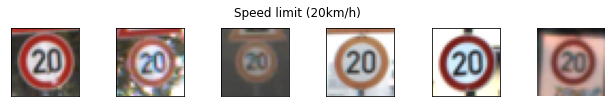

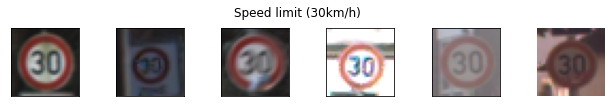

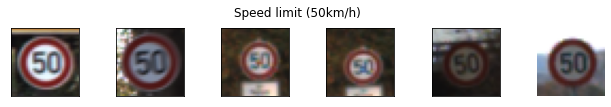

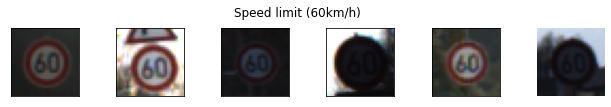

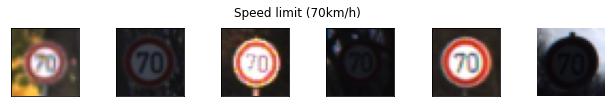

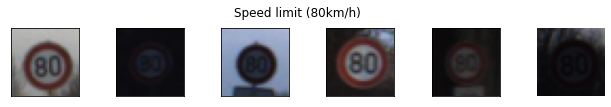

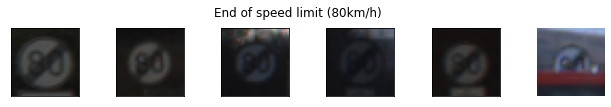

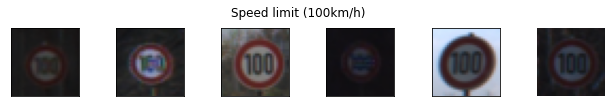

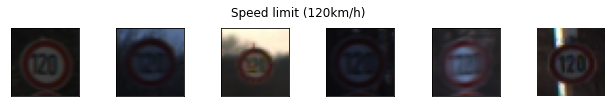

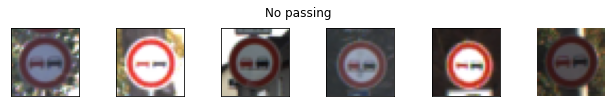

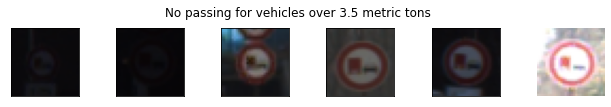

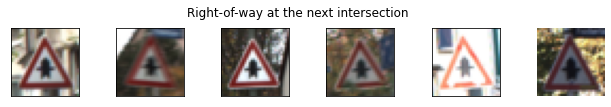

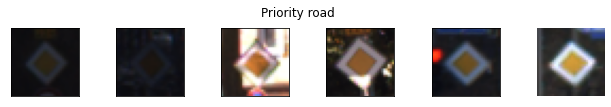

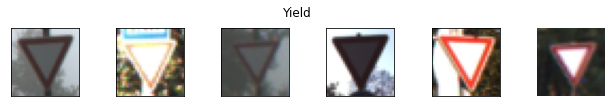

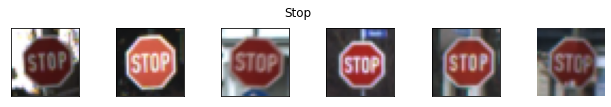

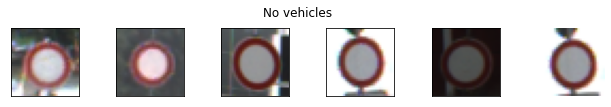

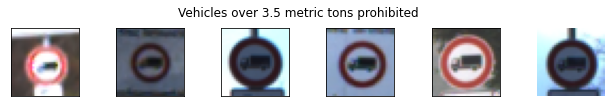

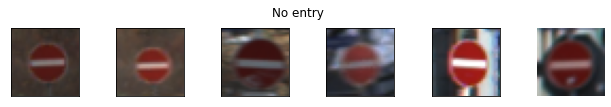

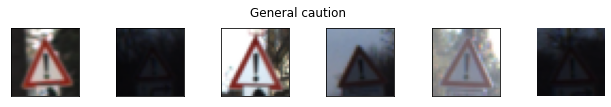

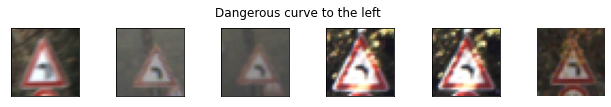

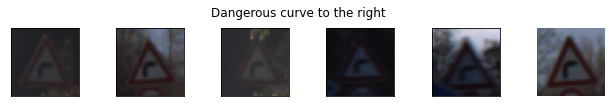

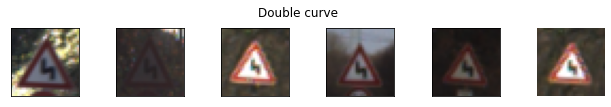

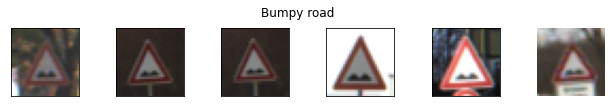

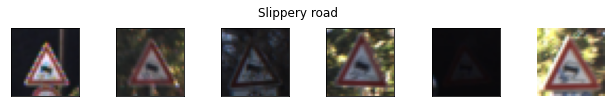

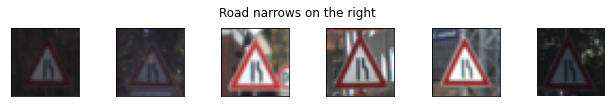

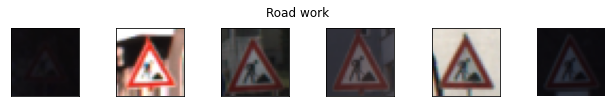

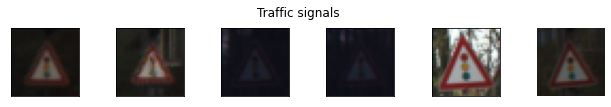

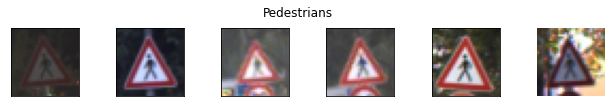

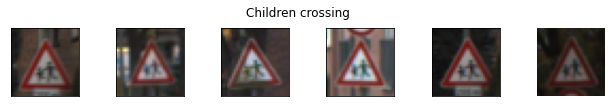

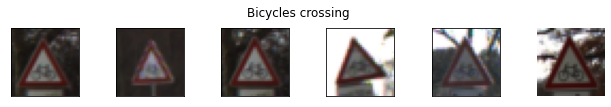

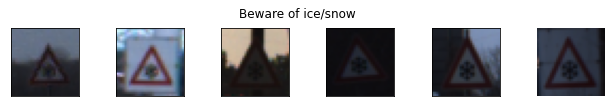

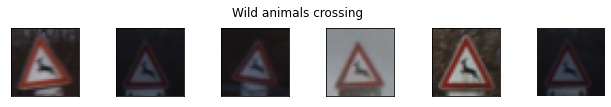

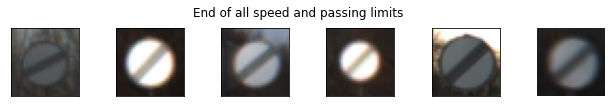

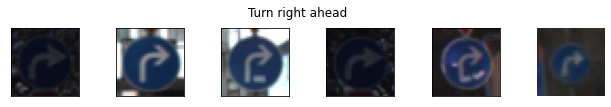

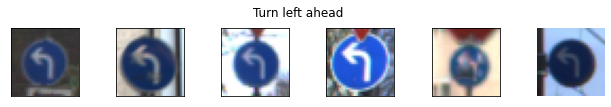

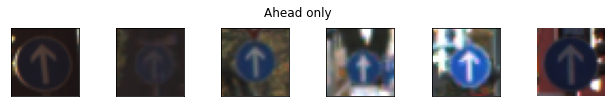

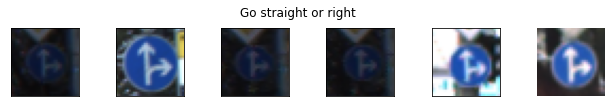

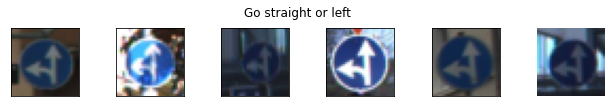

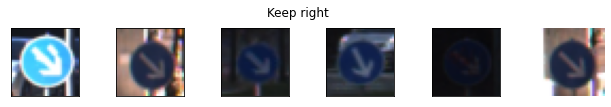

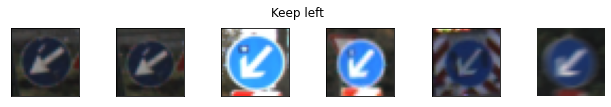

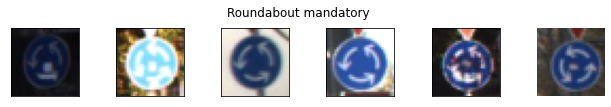

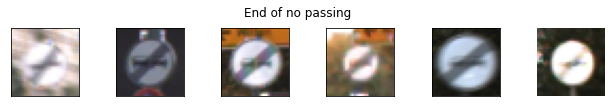

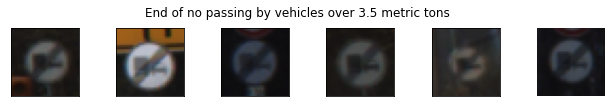

In [134]:
vwr.imShowTrainingSigns(trainingSigns)

#### View Samples Sizes by Training Sign

- Proportions by dataset are about the same across all signs.
- Over half the signs appear to have signficantly less than other signs. Example: "Beware of Ice and snow" is much less than "Speed limit (50km/h)"
- Additional training signs will be generated so model training has a better chance to be exposed to all types of signs.

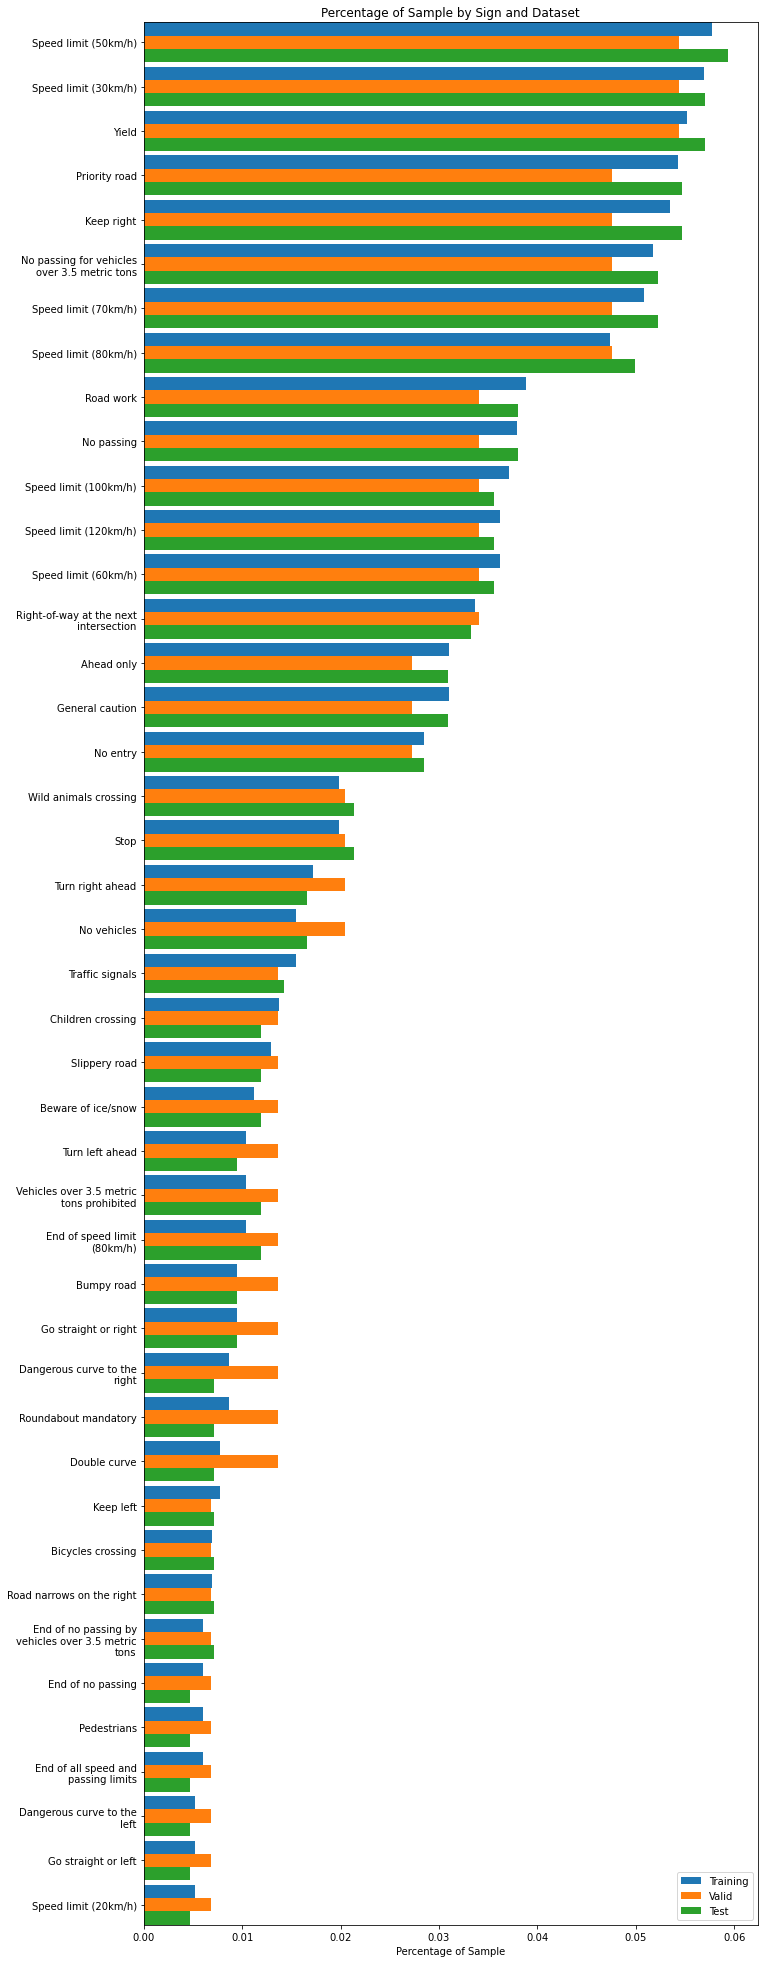

In [135]:
vwr.barhPctBySigns(trainingSigns, validSigns, testSigns)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [136]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

import numpy as np
import cv2
import skimage as sk
from skimage.transform import rotate

#### Helper Functions for Pre-processing

- `equalizeHist()` will brighten dark images
- Global variable `image_processors` is a list of the pre-processor functions applied to datasets before use in training and testing model.
- Other functions such as `shift()`, `zoom()`, etc used in generating additional training samples.

In [137]:
def RGB_to_norm(img):
    return (np.float32(img) - 128)/128

def norm_to_RGB(norm_img):
    return (np.uint8(128 * norm_img) + 128)

def equalizeHist(orgimg, v_thresh=128):
    '''
    Brightens dark images.
    
    Params:
    - orgimg: original image (RGB)
    - v_thresh: max integer of the average value of the image for brightening to occur
    '''
    hsv = cv2.cvtColor(orgimg, cv2.COLOR_RGB2HSV)
    mean_v = np.mean(hsv[:,:,2])
    if mean_v < v_thresh:
        equ = cv2.equalizeHist(hsv[:,:,2])
        hsv[:,:,2] = equ
        img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    else:
        img = orgimg
    return img

image_processors = [equalizeHist, RGB_to_norm]

# https://medium.com/@thimblot/data-augmentation-boost-your-image-dataset-with-few-lines-of-python-155c2dc1baec

def shift(image, d=None):
    '''
    Shifts image left, right, up or down from 1 to 6 pixels. 
    Used in generating additional training samples.
    '''
    if d is None:
        d = random.randint(1, 6)
    direction = random.choice([1, 2, 3, 4])
    if direction == 1:
        image[:-d] = image[d:]
    elif direction == 2:
        image[d:] = image[:-d]
    elif direction == 3:
        image[:,d:] = image[:,:-d]
    else:
        image[:,:-d] = image[:,d:]
        
    return image

def crop(image, size=32):
    '''
    Crops image to 32x32. Used after image is zoomed in.
    '''
    sizes = np.array(image.shape[:2]) - 32
    lower =  sizes // 2
    upper = image.shape[:2] - (lower + (sizes % 2))
    img = image[lower[0]:upper[0], lower[1]:upper[1]]
    return img

def zoom(image, scale=None):
    '''
    Zooms in on an image from 1.0x to 1.6x. Uses crop to ensure img is 32x32
    Used in generating additional training samples.
    '''
    if scale is None:
        scale = random.uniform(1.0, 1.6)
    img = sk.transform.rescale(image, scale, multichannel=True, preserve_range=True).astype(np.uint8)
    return crop(img)

def rotate (image, deg=None):
    '''
    Rotates image from -15 to 15 degrees.
    Used in generating additional training samples.
    '''
    if deg is None:
        deg = random.uniform(-15, 15)
    return sk.transform.rotate(image, deg, preserve_range=True).astype(np.uint8)

def preserve(image):
    '''
    Use same image.
    Used in generating additional training samples.
    '''
    return image.astype(np.uint8)

def fakeify(image):
    '''
    Generates fake images to increase number of training samples.
    
    Notes:
    - Randomly selects from preserve, rotate, zoom, shift to generate image.
    '''
    f = random.choices ([preserve, rotate, zoom, shift], weights=[1, 1, 1, 1])[0]
    return f(image)


#### Examples of Brightening and Fake Generation

TrafficSignsDataset-5640 | Original images and labels restored.


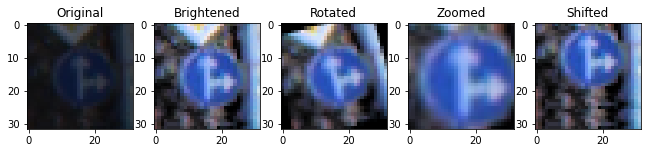

In [174]:
trainingSigns.restoreOrgImages()

org_image = trainingSigns.X[1000].copy()
brt_image = equalizeHist(org_image.copy())
rot_image = rotate(brt_image.copy(), 15)
zm_image  = zoom(brt_image.copy(), 1.6)
shf_image = shift(brt_image.copy(), 6)

images = [org_image, brt_image, rot_image, zm_image, shf_image]
titles  = ["Original", "Brightened", "Rotated", "Zoomed", "Shifted"]

vwr.imShowImages(images, titles)

#### Generate Additional Training Samples

In [139]:
trainingSigns.restoreOrgImages()
trainingSigns.addFakes([fakeify])

TrafficSignsDataset-4832 | Original images and labels restored.
TrafficSignsDataset-4832 | Adding fake images...
TrafficSignsDataset-4832 | Added 1830 fake images for sign classId 0.
TrafficSignsDataset-4832 | Added 30 fake images for sign classId 1.
TrafficSignsDataset-4832 | Added 750 fake images for sign classId 3.
TrafficSignsDataset-4832 | Added 240 fake images for sign classId 4.
TrafficSignsDataset-4832 | Added 360 fake images for sign classId 5.
TrafficSignsDataset-4832 | Added 1650 fake images for sign classId 6.
TrafficSignsDataset-4832 | Added 720 fake images for sign classId 7.
TrafficSignsDataset-4832 | Added 750 fake images for sign classId 8.
TrafficSignsDataset-4832 | Added 690 fake images for sign classId 9.
TrafficSignsDataset-4832 | Added 210 fake images for sign classId 10.
TrafficSignsDataset-4832 | Added 840 fake images for sign classId 11.
TrafficSignsDataset-4832 | Added 120 fake images for sign classId 12.
TrafficSignsDataset-4832 | Added 90 fake images for sig

#### View Some of the Traffic Signs in Training Dataset

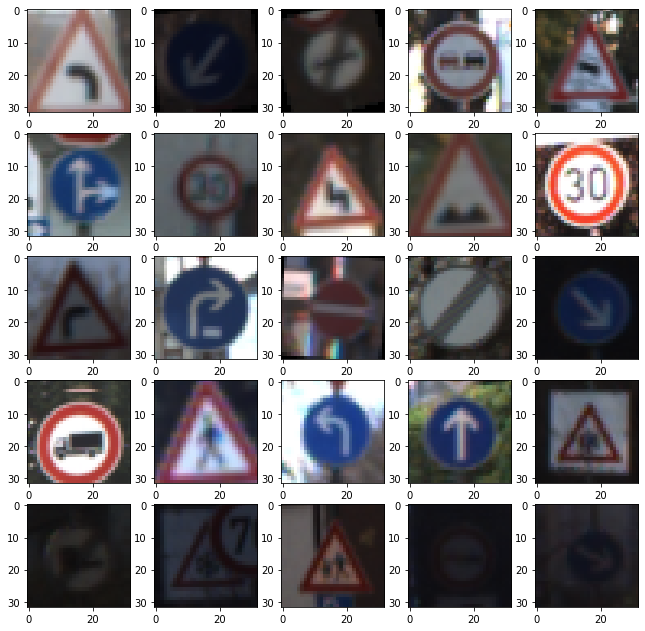

In [140]:
vwr.imShowTrainingSigns5x5(trainingSigns)

#### View Sample Sizes

After generating additional samples for training, the number of samples for each sign should be equal.

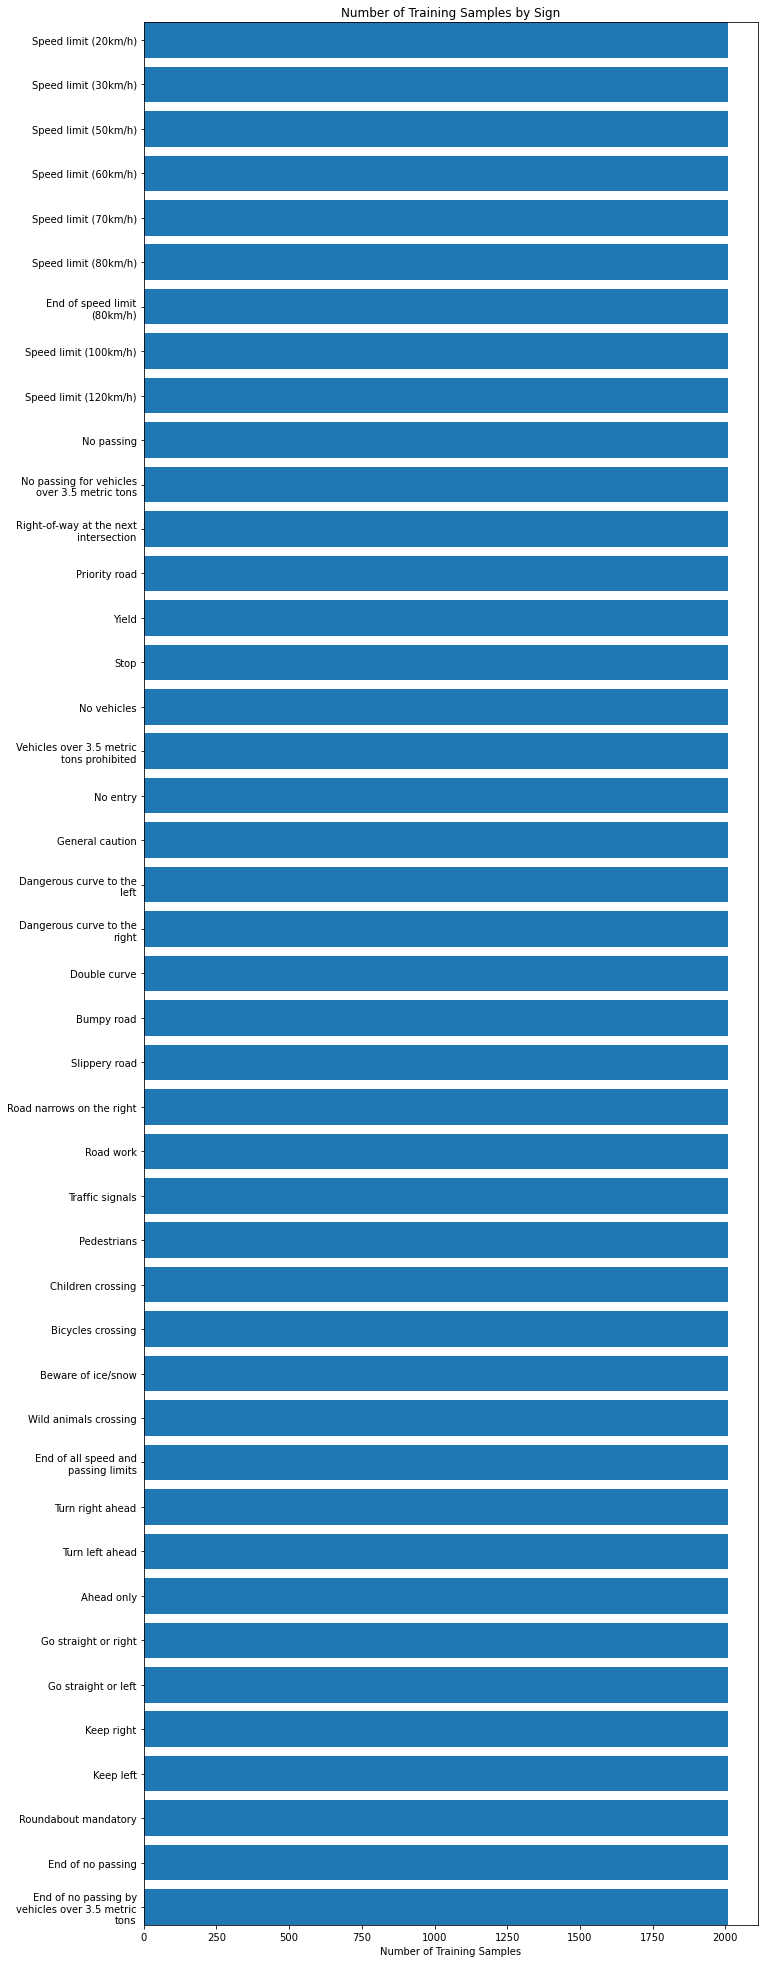

In [141]:
vwr.barhCountTrainingSigns(trainingSigns)

#### Pre-process Datasets

In [142]:
trainingSigns.processImages(image_processors)

validSigns.restoreOrgImages()
validSigns.processImages(image_processors)

testSigns.restoreOrgImages()
testSigns.processImages(image_processors)

TrafficSignsDataset-4832 | Processing images...
TrafficSignsDataset-4832 | Applying equalizeHist() to images.
TrafficSignsDataset-4832 | Applying RGB_to_norm() to images.
TrafficSignsDataset-4832 | ...images processed.
TrafficSignsDataset-2144 | Original images and labels restored.
TrafficSignsDataset-2144 | Processing images...
TrafficSignsDataset-2144 | Applying equalizeHist() to images.
TrafficSignsDataset-2144 | Applying RGB_to_norm() to images.
TrafficSignsDataset-2144 | ...images processed.
TrafficSignsDataset-1920 | Original images and labels restored.
TrafficSignsDataset-1920 | Processing images...
TrafficSignsDataset-1920 | Applying equalizeHist() to images.
TrafficSignsDataset-1920 | Applying RGB_to_norm() to images.
TrafficSignsDataset-1920 | ...images processed.


### Model Architecture

In [143]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from PIL import Image

#### Helper Functions to Define Model Layers

Functions below help to create convolutional, pooling and fully connected layers.

In [144]:
def conv2D(x, output_shape, s=1, mu=0, sigma=0.1, activation=tf.nn.relu):
    
    input_shape = x.shape.as_list()[1:]
    
    input_depth  = input_shape[2]
    output_depth = output_shape[2]
    
    stride = [1, s, s, 1]
    
    # size of filter (length=Width)
    # ref: lesson 12: Solution: Convolution Output Shape for "VALID" padding
    f_ht  = input_shape[0] - output_shape[0]*s + 1
    f_wid = input_shape[1] - output_shape[1]*s + 1
    
    # shape of weights
    w_shape = (f_ht, f_wid, input_depth, output_depth)
    
    w = tf.Variable(tf.truncated_normal(w_shape, mu, sigma))
    b = tf.Variable(tf.zeros(output_depth))
    c = tf.nn.conv2d(x, w, stride, padding='VALID') + b
    a = activation(c)
    
    return a


def pooling(x, output_shape, s=2, pool=tf.nn.max_pool):
    
    input_shape = x.shape.as_list()[1:]
    input_depth = input_shape[2]
    
    # size of filter
    # ref: lesson 23: Quiz: Pooling Mechanics
    f_ht  = input_shape[0] - (output_shape[0] - 1) * s
    f_wid = input_shape[1] - (output_shape[1] - 1) * s
    
    fil    = [1, f_ht, f_wid, 1]
    stride = [1, s, s, 1]
    
    p = pool(x, fil, stride, padding='VALID')
    
    return p


def connected(x, output_shape,  mu=0, sigma=0.1, activation=tf.nn.relu):
    input_shape = x.shape.as_list()[1]
    output_shape = output_shape[0]
    w_shape = (input_shape, output_shape)
    
    w = tf.Variable(tf.truncated_normal(w_shape, mu, sigma))
    b = tf.Variable(tf.zeros(output_shape))
    z = tf.add(tf.matmul(x, w), b)
    
    if activation is None:
        a = z
    else:
        a = activation(z)
    
    return a


#### Class Wrappers for Layers

Classes below wrap the helper functions above. A Keras-inspired convention is used in creating layers and models.

In [145]:
class Layer():
    def __init__(self, output_shape=None):
        self.output_shape = output_shape
        self.tensor = None
        self.model = None
        self.setName()
        return
    
    def setName(self):
        self.name = "Layer"
        return
    
    def summary(self):
        return self.name.ljust(10) + ":" + str(self.tensor.shape)
    
    def connect(self, *prev_layers):
        self.tensor = prev_layers[0].tensor
        return self
    
    def owner(self, model = None):
        if model is not None:
            self.model = model
        return self.model

    
class Input(Layer):
    
    def __init__(self, X):
        
        super().__init__(self)
        self.tensor = X
        
    def setName(self):
        self.name = "Input"
        return
    
    
class Conv2D(Layer):

    def setName(self):
        self.name = "Conv2D"
        return
    
    def connect(self, *prev_layer):
        self.model = prev_layer[0].model
        self.tensor = conv2D(prev_layer[0].tensor, self.output_shape)
        return self
    

class Pooling(Layer):
    
    def setName(self):
        self.name = "Pooling"
        return
    
    def connect(self, *prev_layer):
        self.model = prev_layer[0].model
        self.tensor = pooling(prev_layer[0].tensor, self.output_shape)
        return self
    
    
class Dropout(Layer):
    
    def setName(self):
        self.name = "Dropout"
        return

    def connect(self, *prev_layer):
        self.model = prev_layer[0].model
        self.keep_prob = self.model.keep_prob
        self.tensor = tf.nn.dropout(prev_layer[0].tensor, self.keep_prob)
        return self
    

class Flatten(Layer):
    
    def setName(self):
        self.name = "Flatten"
        return

    def connect(self, *prev_layer):
        self.model = prev_layer[0].model
        self.tensor = flatten(prev_layer[0].tensor)
        return self
    
    
class Connected(Layer):

    def setName(self):
        self.name = "Connected"
        return
    
    def connect(self, *prev_layer):
        self.model = prev_layer[0].model
        self.tensor = connected(prev_layer[0].tensor, self.output_shape)
        return self


#### Class for Defining a Deep Neural Network

A base `Model` class and `Sequential` Model Keras-inspired classed are defined below. The base `Model` class is used to construct a multi-scale network then Optional section of this project. The more traditional `Sequential` is used to construct the main classifier for this project.

In [146]:
class Model:
    
    def __init__(self, name, input_shape, n_classes):
        self.logger = Logger('Model', self)
        
        self.name = name
        
        x_shape = (None, input_shape[0], input_shape[1], input_shape[2])
        self.x  = tf.placeholder(tf.float32, x_shape)
        
        self.input_layer = Input(self.x)
        self.input_layer.owner(self)
        
        self.y         = tf.placeholder(tf.int32, (None))
        self.keep_prob = tf.placeholder(tf.float32)

        self.n_classes = n_classes
        self.logits    = None
        self.saver     = None 
        self.acc_history = None
        
        return
    
    def inputLayer(self):
        return self.input_layer
    
    def connectLogits(self, prev_layer):
    
        self.logits = connected(prev_layer.tensor, [self.n_classes], activation=None)

        oh_labels      = tf.one_hot(self.y, self.n_classes)
        losses         = tf.nn.softmax_cross_entropy_with_logits(labels=oh_labels, logits=self.logits)
        self.mean_loss = tf.reduce_mean(losses)
        
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(oh_labels, 1))
        self.tot_correct   = tf.reduce_sum(tf.cast(correct_prediction, tf.float32))
    
    def accuracy(self, X_data, y_data, batch_size):
        
        num_examples = len(X_data)
        total_correct = 0
        sess = tf.get_default_session()        
        
        for offset in range(0, num_examples, batch_size):
            
            batch_x   = X_data[offset:offset+batch_size] 
            batch_y   = y_data[offset:offset+batch_size]
            feed_dict = {self.x: batch_x, 
                         self.y: batch_y, 
                         self.keep_prob: 1.0}
            
            batch_correct = sess.run(self.tot_correct, feed_dict=feed_dict)
            total_correct += batch_correct
            
        return round (total_correct / num_examples, 3)
    
    def saveModel(self):
        
        sess = tf.get_default_session()
        self.saver.save(sess, "checkpoints/" + self.name)
        msg = "{} saved."
        self.logger.log(msg.format(self.name))
        
        return
    
    def afterEpoch(self, epoch, i, acc, acc_save, hi_acc):
        self.acc_history.append(acc)
        i += 1
        if acc > acc_save:
            if acc > hi_acc:
                i = 0
                hi_acc = acc
                msg = "Epoch {:4d} - New High Acc: {:.3f}"
                self.logger.log(msg.format(epoch + 1, hi_acc))
                
                self.saveModel()
            else:
                msg = "Epoch {:4d} - Acc: {:.3f} - Highest: {:.3f}"
                self.logger.log(msg.format(epoch + 1, acc, hi_acc))
        elif hi_acc > 0:
            msg = "Epoch {:4d} -  Acc: {:.3f} - Highest: {:.3f}"
            self.logger.log(msg.format(epoch + 1, acc, hi_acc))
        else:
            msg = "Epoch {:4d} - Acc: {:.3f}"
            self.logger.log(msg.format(epoch + 1, acc))

        epoch += 1
            
        return epoch, i, hi_acc
    
    def train(self, training_data, validation_data, epochs_done, batch_size, lr=0.001, 
              acc_save=0.93, acc_done=0.982, keep_prob=1.0, ):
        
        X_train = training_data[0]
        y_train = training_data[1]
        
        X_valid = validation_data[0]
        y_valid = validation_data[1]
        
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        minimizer = optimizer.minimize(self.mean_loss)
        
        self.saver = tf.train.Saver()
        
        self.logger.log("Training...")
        with tf.Session() as sess:
            try:
            
                sess.run(tf.global_variables_initializer())

                num_examples = len(X_train)

                self.acc_history = []
                hi_acc = 0
                epoch = 0
                i = 0
                acc = 0
                while (i < epochs_done) and (acc < acc_done):

                    X_train, y_train = shuffle(X_train, y_train)

                    for offset in range(0, num_examples, batch_size):
                        end       = offset + batch_size
                        batch_x   = X_train[offset:end] 
                        batch_y   = y_train[offset:end]
                        feed_dict = {self.x        : batch_x, 
                                     self.y        : batch_y, 
                                     self.keep_prob: keep_prob}
                        sess.run(minimizer, feed_dict=feed_dict)

                    acc = self.accuracy(X_valid, y_valid, batch_size)
                    epoch, i, hi_acc = self.afterEpoch(epoch, i, acc, acc_save, hi_acc)
                    
            # https://stackoverflow.com/a/45033800
            except KeyboardInterrupt:
                self.logger.log("Manually terminated.")

        msg = "...training complete. Highest accuracy: {:.3f}."
        self.logger.log(msg.format(hi_acc))        
        
        return
    
    def accHist(self):
        return self.acc_history
    
    def test(self, test_data):
        
        X_test = test_data[0]
        y_test = test_data[1]
        
        with tf.Session() as sess:
            self.restore()
            test_acc = self.accuracy(X_test, y_test, batch_size=128)
            msg = "Test accuracy: {:.3f}."
            self.logger.log(msg.format(test_acc))
            
        return
    
    def predict(self, images, top=5):
        
        with tf.Session() as sess:
            
            self.restore()
            predictions = []
            
            self.logger.log("Classifying images...")
            
            op_top_k  = tf.nn.top_k(tf.nn.softmax(self.logits), top)
            feed_dict = {self.x        : images, 
                         self.keep_prob: 1.0}

            predictions = sess.run(op_top_k, feed_dict=feed_dict)

            msg = "...{} images classified."
            self.logger.log(msg.format(len(images)))
            
        return predictions
    
    def restore(self):

        saver = tf.train.Saver()
        sess  = tf.get_default_session()
        saver.restore(sess, "checkpoints/" + self.name)
        
        msg = "{} restored."
        self.logger.log(msg.format(self.name))        
        
        return
    
class Sequential(Model):
    
    def __init__(self, name, input_shape, n_classes):
        
        super().__init__(name, input_shape, n_classes)
        self.layers    = []
        
        return
        
    def addLayer(self, layer):
        
        self.layers.append(layer)
        
        return
    
    def assemble(self):
        
        prev_layer = self.input_layer
        for layer in self.layers:
            prev_layer = layer.connect(prev_layer)
            
        self.connectLogits(prev_layer)
        
        msg = "{} assembled."
        self.logger.log(msg.format(self.name))
            
        return 
    
    def summarize(self):
        
        msg = "     Summary for {}:"
        self.logger.log(msg.format(self.name))
        self.logger.log("----------------------------------")
        msg = "     Input".ljust(15) + ":{}"
        self.logger.log(msg.format(self.x.shape))
        self.logger.log("----------------------------------")
        
        n = 0
        for layer in self.layers:
            msg = "{:<2} : " + layer.summary()
            self.logger.log(msg.format(n))
            n += 1

        self.logger.log("----------------------------------")
        msg = "     Logits".ljust(15) + ":{}"
        self.logger.log(msg.format(self.logits.shape))
        self.logger.log("----------------------------------")
            
        return
    
    def eval_layer(self, i, img):
        
        msg = "Evaluating layer {}."
        self.logger.log(msg.format(i))
        
        tensor = self.layers[i].tensor
        feed_dict = {self.x        : [img], 
                     self.keep_prob: 1.0}

        with tf.Session() as sess:
            
            self.restore()
            eval_outputs = tensor.eval(session=sess, feed_dict=feed_dict)
            
        msg = "Output shape: {}."
        self.logger.log(msg.format(eval_outputs.shape))

        return eval_outputs

#### Model Architecture for Traffic Sign Classifier

The `Sequential` model is used to add the layers to develop the classifiers. Layers are added "sequentially" to the model. 

The model architecture generally follows the LeNet architecture outlined in Lesson 13: Convolutional Neural Networks, Item 36. Lab: LeNet in Tensorflow. 

A 1x1 convolution used in the very first layer has an output shape of 32x32x1. During development, this allowed the sequential model to improve validation accuracy as compared to training the model without it.

The other convolutional layers have the same first and second dimensions as the LeNet, but are deeper. The fully connected layers are wider with dropout added in the later stages.

In [147]:
notLenet = Sequential("notLeNet", input_shape=image_shape, n_classes=n_classes)

notLenet.addLayer (Conv2D   ([32, 32, 1]))
notLenet.addLayer (Conv2D   ([28, 28, 24]))
notLenet.addLayer (Pooling  ([14, 14]))
notLenet.addLayer (Conv2D   ([10, 10, 64]))
notLenet.addLayer (Pooling  ([5, 5]))
notLenet.addLayer (Flatten  ())
notLenet.addLayer (Connected([240]))
notLenet.addLayer (Dropout  ())    
notLenet.addLayer (Connected([168]))
notLenet.addLayer (Dropout  ())

notLenet.assemble()

Model-4360 | notLeNet assembled.


#### Print Model Summary

Layers and respective output shapes are printed to verify architecture.

In [148]:
notLenet.summarize()

Model-4360 |      Summary for notLeNet:
Model-4360 | ----------------------------------
Model-4360 |      Input     :(?, 32, 32, 3)
Model-4360 | ----------------------------------
Model-4360 | 0  : Conv2D    :(?, 32, 32, 1)
Model-4360 | 1  : Conv2D    :(?, 28, 28, 24)
Model-4360 | 2  : Pooling   :(?, 14, 14, 24)
Model-4360 | 3  : Conv2D    :(?, 10, 10, 64)
Model-4360 | 4  : Pooling   :(?, 5, 5, 64)
Model-4360 | 5  : Flatten   :(?, 1600)
Model-4360 | 6  : Connected :(?, 240)
Model-4360 | 7  : Dropout   :(?, 240)
Model-4360 | 8  : Connected :(?, 168)
Model-4360 | 9  : Dropout   :(?, 168)
Model-4360 | ----------------------------------
Model-4360 |      Logits    :(?, 43)
Model-4360 | ----------------------------------


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [149]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

'''
Batch size of batch_size=128 was chosen through trial and error. 
Training terminates once epochs_done=128 epochs have passed 
since last highest validation accuracy was detected. 
If validation accuracy reaches acc_done=0.99, training will also terminate. 
Model is saved every time a new high accuracy is achieved. 
Keep probability for the dropout layers is keep_prob=0.5.
'''
notLenet.train(trainingSigns.data(), validSigns.data(), batch_size=128, 
        epochs_done=64, acc_done=0.997, keep_prob=0.5)

Model-4360 | Training...
Model-4360 | Epoch    1 - Acc: 0.641
Model-4360 | Epoch    2 - Acc: 0.899
Model-4360 | Epoch    3 - New High Acc: 0.933
Model-4360 | notLeNet saved.
Model-4360 | Epoch    4 - New High Acc: 0.951
Model-4360 | notLeNet saved.
Model-4360 | Epoch    5 - New High Acc: 0.960
Model-4360 | notLeNet saved.
Model-4360 | Epoch    6 - New High Acc: 0.964
Model-4360 | notLeNet saved.
Model-4360 | Epoch    7 - New High Acc: 0.968
Model-4360 | notLeNet saved.
Model-4360 | Epoch    8 - Acc: 0.962 - Highest: 0.968
Model-4360 | Epoch    9 - Acc: 0.962 - Highest: 0.968
Model-4360 | Epoch   10 - New High Acc: 0.970
Model-4360 | notLeNet saved.
Model-4360 | Epoch   11 - New High Acc: 0.971
Model-4360 | notLeNet saved.
Model-4360 | Epoch   12 - Acc: 0.966 - Highest: 0.971
Model-4360 | Epoch   13 - Acc: 0.970 - Highest: 0.971
Model-4360 | Epoch   14 - New High Acc: 0.974
Model-4360 | notLeNet saved.
Model-4360 | Epoch   15 - New High Acc: 0.976
Model-4360 | notLeNet saved.
Model-4360

#### Plot Accuracy over Epochs

Model achieved a validation accuracy of 98.5% at epoch 143. Plot below shows performace over epochs.

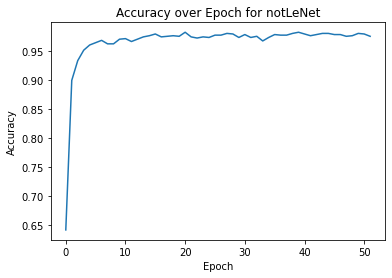

In [150]:
vwr.plotAccHist(notLenet.name, notLenet.accHist())

#### Check Accuracy with Training Data
Accuracy should be 1.00 or very high for training data.

In [151]:
notLenet.test(trainingSigns.data())

Model-4360 | notLeNet restored.
Model-4360 | Test accuracy: 0.999.


#### Check Model Accuracy with Test Data

In [152]:
notLenet.test(testSigns.data())

Model-4360 | notLeNet restored.
Model-4360 | Test accuracy: 0.964.


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

TrafficSignsDataset-1216 | Loading signs from traffic_signs/wikipedia/...
TrafficSignsDataset-1216 | Loaded 10,No passing for vehicles over 3.5 metric tons.png with label 10.
TrafficSignsDataset-1216 | Loaded 19,Dangerous curve to the left.png with label 19.
TrafficSignsDataset-1216 | Loaded 21,Double curve.png with label 21.
TrafficSignsDataset-1216 | Loaded 22,Bumpy road.png with label 22.
TrafficSignsDataset-1216 | Loaded 24,Road narrows on the right.png with label 24.
TrafficSignsDataset-1216 | Loaded 26,Traffic signals.png with label 26.
TrafficSignsDataset-1216 | Loaded 29,Bicycles crossing.png with label 29.
TrafficSignsDataset-1216 | Loaded 3,Speed limit (60kmh).png with label 3.
TrafficSignsDataset-1216 | Loaded 30,Beware of ice-snow.png with label 30.
TrafficSignsDataset-1216 | Loaded 32,End of all speed and passing limits.png with label 32.
TrafficSignsDataset-1216 | Loaded 35,Ahead only.png with label 35.
TrafficSignsDataset-1216 | Loaded 40,Roundabout mandatory.png with la

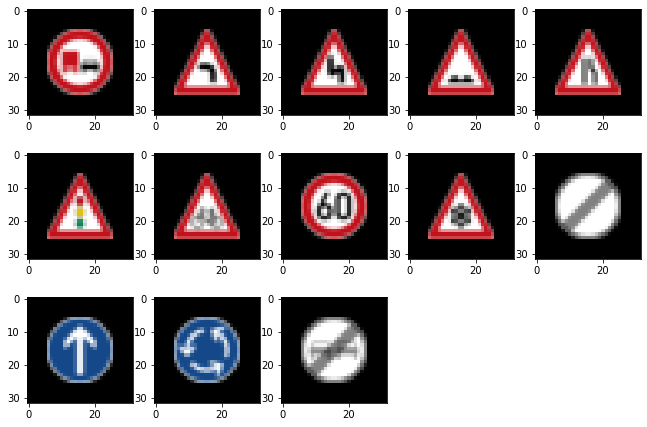

In [175]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

folder_name = 'traffic_signs/wikipedia/'
wiki_traffic_signs = TrafficSignsDataset (folder_name, n_classes)
vwr.imShowImages(wiki_traffic_signs.X)

### Predict the Sign Type for Each Image

In [154]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

wiki_traffic_signs.restoreOrgImages()
wiki_traffic_signs.processImages(image_processors)

TrafficSignsDataset-1640 | Original images and labels restored.
TrafficSignsDataset-1640 | Processing images...
TrafficSignsDataset-1640 | Applying equalizeHist() to images.
TrafficSignsDataset-1640 | Applying RGB_to_norm() to images.
TrafficSignsDataset-1640 | ...images processed.


### Analyze Performance

In [155]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

notLenet.test(wiki_traffic_signs.data())

Model-4360 | notLeNet restored.
Model-4360 | Test accuracy: 1.000.


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

Model-4360 | notLeNet restored.
Model-4360 | Classifying images...
Model-4360 | ...13 images classified.


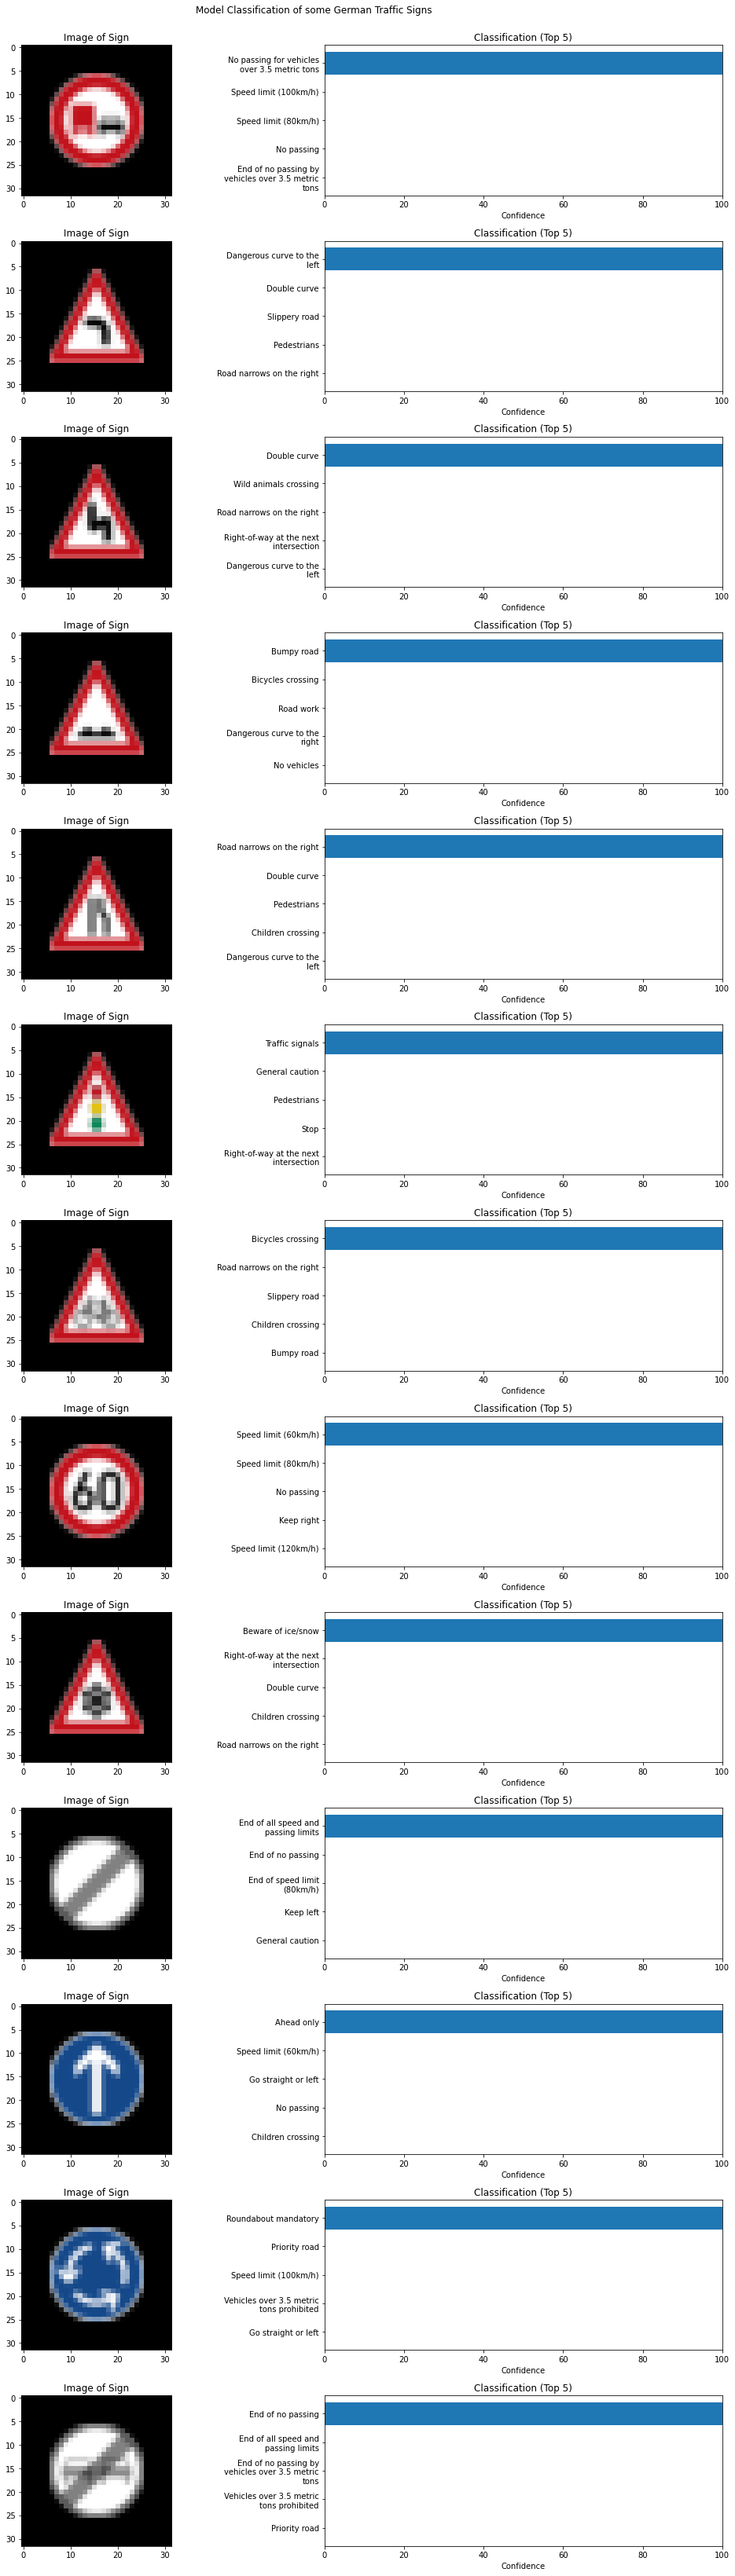

In [156]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

predictions = notLenet.predict(wiki_traffic_signs.X, top=5)
vwr.imShowPredictions(wiki_traffic_signs.org_X, predictions)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [157]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

#### Select and Preprocess Image for Network State Visualization

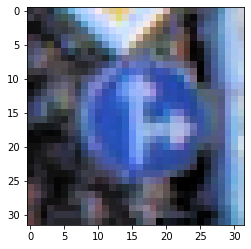

In [159]:
x = trainingSigns.org_X[1000].copy()

equ = equalizeHist(x)
img = RGB_to_norm(equ)

plt.imshow(norm_to_RGB(img))

#### Generate Layer 0 Feature Map with Image

Model-4360 | Evaluating layer 0.
Model-4360 | notLeNet restored.
Model-4360 | Output shape: (1, 32, 32, 1).


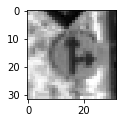

In [160]:
layer_outputs = notLenet.eval_layer(0, img)
vwr.imShowConvOutputs(layer_outputs)

#### Generate Layer 1 Feature Map with Image

Model-4360 | Evaluating layer 1.
Model-4360 | notLeNet restored.
Model-4360 | Output shape: (1, 28, 28, 24).


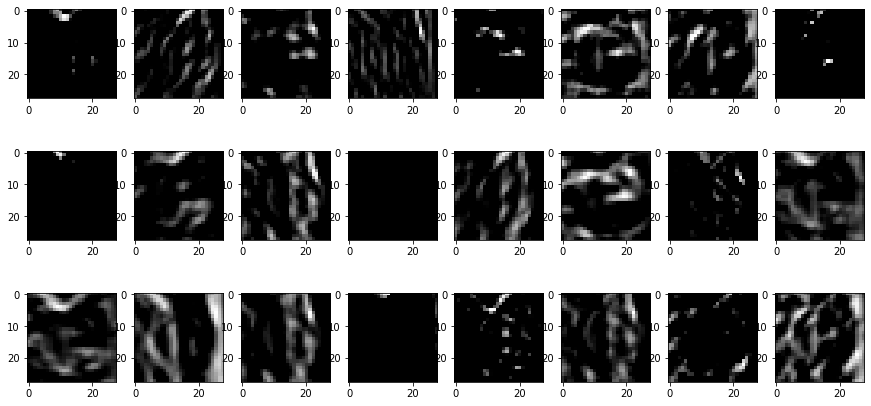

In [161]:
layer_outputs = notLenet.eval_layer(1, img)
vwr.imShowConvOutputs(layer_outputs)

---

## Super Optional: Attempt to Replicate Multi-Scale CNN

Just out of curiosity, a multi-scale CNN is attempted.

### Concatenation Layer

A layer that concatenates flattened layers is required.

In [162]:
class Concatenate(Layer):
    
    def setName(self):
        self.name = "Concatenate"
        return

    def connect(self, *prev_layers):
        self.model = prev_layers[0].model
        tensors = [layer.tensor for layer in prev_layers]
        self.tensor = tf.concat(tensors, axis=1)
        return self

### Create Multi-Scale Architecture

The architecture is similar to the one Sermanet and Lecunn described in "Traffic Sign Recognition with Multi-Scale Convolutional Networks" where the output of the second stage is feed to the classifier stage.

In [163]:
tf.reset_default_graph()

notSermanet = Model("notSermanet", image_shape, n_classes)

stage_1x1 = Conv2D ([32, 32, 1]).connect(notSermanet.inputLayer())

stage_1 = Conv2D ([28, 28, 24]).connect(stage_1x1)
stage_1 = Pooling([14, 14]).connect(stage_1)
flatten_1 = Flatten().connect(stage_1)

stage_2 = Conv2D ([10, 10, 64]).connect(stage_1)
stage_2 = Pooling([ 5,  5]).connect(stage_2)
stage_2 = Conv2D ([3, 3, 96]).connect(stage_2)
flatten_2 = Flatten().connect(stage_2)

stage_3 = Concatenate().connect(flatten_1, flatten_2)
stage_3 = Connected([240]).connect(stage_3)
stage_3 = Dropout().connect(stage_3)
stage_3 = Connected([168]).connect(stage_3)
stage_3 = Dropout().connect(stage_3)

notSermanet.connectLogits(stage_3)

### Train Multi-Scale CNN

In [164]:
notSermanet.train(trainingSigns.data(), validSigns.data(), batch_size=64, 
        epochs_done=128, acc_done=0.997, keep_prob=0.5)

Model-1808 | Training...
Model-1808 | Epoch    1 - Acc: 0.870
Model-1808 | Epoch    2 - New High Acc: 0.939
Model-1808 | notSermanet saved.
Model-1808 | Epoch    3 - New High Acc: 0.953
Model-1808 | notSermanet saved.
Model-1808 | Epoch    4 - New High Acc: 0.962
Model-1808 | notSermanet saved.
Model-1808 | Epoch    5 - New High Acc: 0.972
Model-1808 | notSermanet saved.
Model-1808 | Epoch    6 - New High Acc: 0.974
Model-1808 | notSermanet saved.
Model-1808 | Epoch    7 - Acc: 0.974 - Highest: 0.974
Model-1808 | Epoch    8 - Acc: 0.971 - Highest: 0.974
Model-1808 | Epoch    9 - Acc: 0.973 - Highest: 0.974
Model-1808 | Epoch   10 - New High Acc: 0.976
Model-1808 | notSermanet saved.
Model-1808 | Epoch   11 - New High Acc: 0.977
Model-1808 | notSermanet saved.
Model-1808 | Epoch   12 - Acc: 0.973 - Highest: 0.977
Model-1808 | Epoch   13 - Acc: 0.977 - Highest: 0.977
Model-1808 | Epoch   14 - Acc: 0.967 - Highest: 0.977
Model-1808 | Epoch   15 - Acc: 0.977 - Highest: 0.977
Model-1808 | E

### Plot Accuracy over Epochs

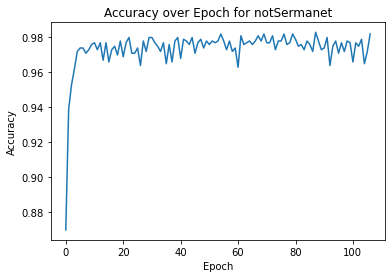

In [165]:
vwr.plotAccHist(notSermanet.name, notSermanet.accHist())

### Check Accuracy with Test Data

In [166]:
notSermanet.test(testSigns.data())

Model-1808 | notSermanet restored.
Model-1808 | Test accuracy: 0.962.


### Check Accuracy with Downloaded Traffic Signs

In [167]:
notSermanet.test(wiki_traffic_signs.data())

Model-1808 | notSermanet restored.
Model-1808 | Test accuracy: 1.000.


### View Model Classifications of Downloaded Traffic Signs

Model-1808 | notSermanet restored.
Model-1808 | Classifying images...
Model-1808 | ...13 images classified.


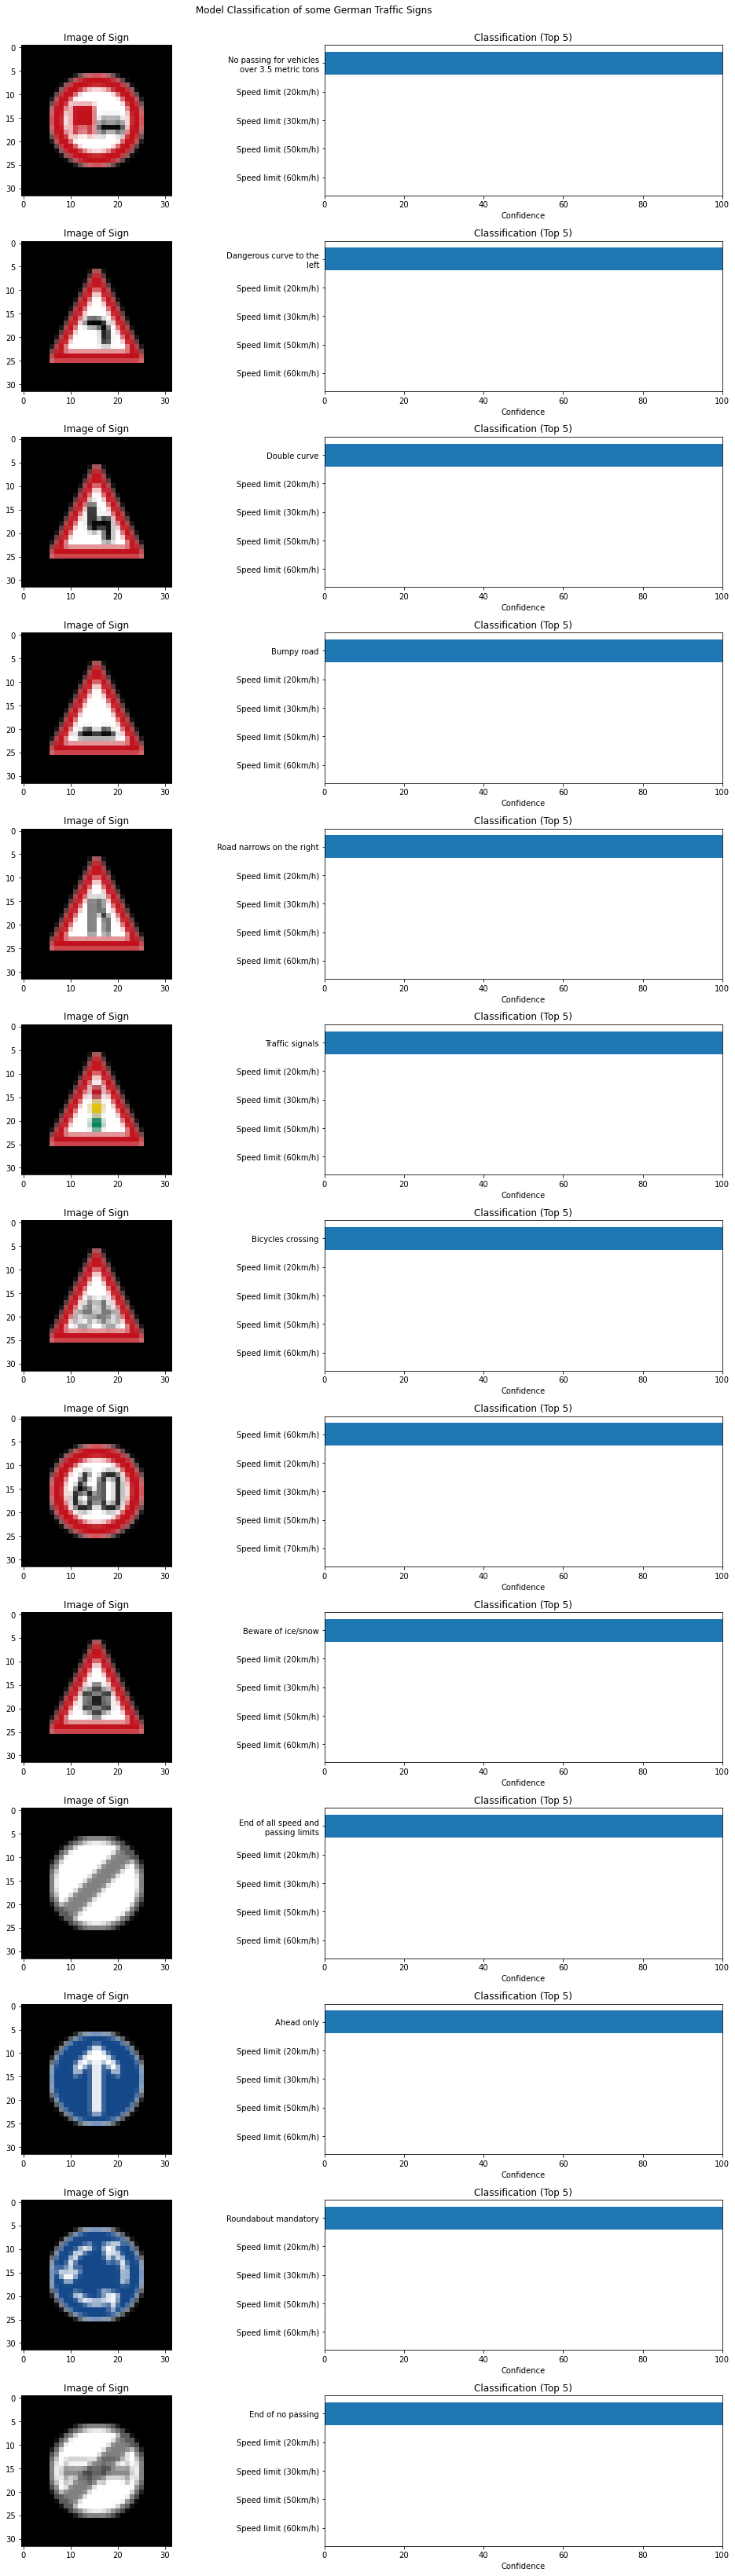

In [168]:
predictions = notSermanet.predict(wiki_traffic_signs.X, top=5)
vwr.imShowPredictions(wiki_traffic_signs.org_X, predictions)